In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spacetitanic/train.csv
/kaggle/input/spacetitanic/test.csv
/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2
from statsmodels.multivariate.manova import MANOVA
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.model_selection import GridSearchCV
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter

In [3]:
train = pd.read_csv('/kaggle/input/spacetitanic/train.csv') # 8693, 14
test = pd.read_csv('/kaggle/input/spacetitanic/test.csv') # 4277, 13

In [4]:
def inputanalysis(input):
    print(input.describe())
    print("\n", input.info())
    print("\n", input.isna().sum())
    print(input.duplicated())

In [5]:
inputanalysis(train)
inputanalysis(test)

               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 co

In [6]:
def preprocess(data):
    data[['Group', 'Person']] = data['PassengerId'].str.split('_', expand=True)
    data.drop('PassengerId', axis=1, inplace=True)
    
    data[['Deck', 'Num', 'Side']] = data['Cabin'].str.split('/', expand=True)
    data.drop('Cabin', axis=1, inplace=True)
    
    data[['fName', 'lName']] = data['Name'].str.split(' ', expand=True)
    data.drop('Name', axis=1, inplace=True)
    

In [7]:
preprocess(train)
preprocess(test)

In [8]:
cols = ['VIP', 'CryoSleep']
train[cols] = train[cols].astype(bool)
train['Num'] = train['Num'].astype(float)
test[cols] = test[cols].astype(bool)
test['Num'] = test['Num'].astype(float)

In [9]:
imputer = SimpleImputer(strategy='most_frequent')

imp1_col = ['HomePlanet','Destination','Deck','Side']
imp2_col = ['Age', 'RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Num']

def clean(df):
    df[imp1_col] = imputer.fit_transform(df[imp1_col])
    df['fName'].fillna('Unknown', inplace=True)
    df['lName'].fillna('Unknown', inplace=True)
    for i in imp2_col:
      df[i] =df[i].interpolate().round(0)
      pd.concat([df, pd.DataFrame(df[i])], ignore_index=True)

In [10]:
clean(train)
clean(test)

In [11]:
dist1 = pd.DataFrame(train, columns =['RoomService', 'ShoppingMall','Spa', 'VRDeck','FoodCourt','Num'])
bins1 = [0,1000,2000,5000,25000]
bins2 = [0, 300,600,1500,1900]
import pandas as pd

In [12]:
def calculate_frequency(df):
    frequency_dict = {}
    for column in df.columns:
        # Skip non-numeric columns
        if pd.api.types.is_numeric_dtype(df[column]):
            if column == 'Num':
                bins = bins2
                range_column = f'range_{column}'
                df[range_column] = pd.cut(df[column], bins)
                
                # Calculate frequency of each range
                frequency = df[range_column].value_counts().reset_index()
                frequency.columns = [range_column, f'frequency_{column}']
                # Store the frequency data in a dictionary
                frequency_dict[column] = frequency
            else:
                bins = bins1
                # Create a new column for the ranges
                range_column = f'range_{column}'
                df[range_column] = pd.cut(df[column], bins)
                
                # Calculate frequency of each range
                frequency = df[range_column].value_counts().reset_index()
                frequency.columns = [range_column, f'frequency_{column}']
                
                # Store the frequency data in a dictionary
                frequency_dict[column] = frequency
    
    return frequency_dict

In [13]:
frequency_dict = calculate_frequency(dist1)
frequency_dfs = list(frequency_dict.values())

# Concatenate the DataFrames into a single DataFrame
result_df = pd.concat(frequency_dfs, axis=1)
result_df

,range_RoomService,frequency_RoomService,range_ShoppingMall,frequency_ShoppingMall,range_Spa,frequency_Spa,range_VRDeck,frequency_VRDeck,range_FoodCourt,frequency_FoodCourt,range_Num,frequency_Num
0,"(0, 1000]",2429,"(0, 1000]",2628,"(0, 1000]",2650,"(0, 1000]",2467,"(0, 1000]",2270,"(0, 300]",3630
1,"(1000, 2000]",406,"(1000, 2000]",259,"(1000, 2000]",300,"(1000, 2000]",307,"(2000, 5000]",375,"(600, 1500]",2972
2,"(2000, 5000]",179,"(2000, 5000]",108,"(2000, 5000]",251,"(2000, 5000]",217,"(1000, 2000]",328,"(300, 600]",1529
3,"(5000, 25000]",28,"(5000, 25000]",16,"(5000, 25000]",99,"(5000, 25000]",110,"(5000, 25000]",180,"(1500, 1900]",544


In [14]:
cls = ['RoomService', 'ShoppingMall', 'Spa', 'VRDeck', 'FoodCourt','Num','Age']

def Num_dist(df):
    for j in cls:
        num_dist = []

        if j == 'Num':
            for i in df[j]:
                if i <= 300:
                    num_dist.append("very_high")
                elif 300 < i <= 600:
                    num_dist.append("medium")
                elif 600 < i <= 1500:
                    num_dist.append("high")
                else:
                    num_dist.append("0")
            df["num_class"] = num_dist

        elif (j != 'Num' and j !='Age'):
            new_column_name = f"{j}_class"
            for i in df[j]:
                if i <= 1000:
                    num_dist.append("very_high")
                elif 1000 < i <= 2000:
                    num_dist.append("high")
                elif 2000 < i <= 5000:
                    num_dist.append("medium")
                elif 5000 < i <= 25000:
                    num_dist.append("low")
                else:
                    num_dist.append("0")
            df[new_column_name] = num_dist
        else:
            new_column_name = f"{j}_class"
            for i in df[j]:
                if i<=12:
                    num_dist.append("Age_0-12")
                elif (i>12 and i<=18):
                    num_dist.append("Age_13-18")
                elif (i>18 and i<=25):
                    num_dist.append("Age_19-25")
                elif (i>25 and i<=32):
                    num_dist.append("Age_26-32")
                elif (i>32 and i<=50):
                    num_dist.append("Age_33_50")
                elif (i>50):
                    num_dist.append("age_50+")
                else:
                    num_dist.append("0")
            df[new_column_name] = num_dist

    return df

In [15]:
Num_dist(train)
Num_dist(test)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Side,fName,lName,RoomService_class,ShoppingMall_class,Spa_class,VRDeck_class,FoodCourt_class,num_class,Age_class
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,...,S,Nelly,Carsoning,very_high,very_high,very_high,very_high,very_high,very_high,Age_26-32
1,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,...,S,Lerome,Peckers,very_high,very_high,medium,very_high,very_high,very_high,Age_19-25
2,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,...,S,Sabih,Unhearfus,very_high,very_high,very_high,very_high,very_high,very_high,Age_26-32
3,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,...,S,Meratz,Caltilter,very_high,very_high,very_high,very_high,low,very_high,Age_33_50
4,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,...,S,Brence,Harperez,very_high,very_high,very_high,very_high,very_high,very_high,Age_19-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,...,S,Jeron,Peter,very_high,very_high,very_high,very_high,very_high,high,Age_33_50
4273,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,...,S,Matty,Scheron,very_high,very_high,very_high,very_high,very_high,high,Age_33_50
4274,Mars,True,55 Cancri e,42.0,False,0.0,0.0,0.0,0.0,0.0,...,P,Jayrin,Pore,very_high,very_high,very_high,very_high,very_high,very_high,Age_33_50
4275,Europa,False,TRAPPIST-1e,43.0,False,0.0,2680.0,0.0,0.0,523.0,...,P,Kitakan,Conale,very_high,very_high,very_high,very_high,medium,very_high,Age_33_50


In [16]:
def encode_categorical_columns(df, boolean_columns):

    # Define categorical columns and categories
    categorical_columns = ['HomePlanet', 'Destination', 'Deck', 'Side', 'RoomService_class', 'ShoppingMall_class', 'Spa_class', 'VRDeck_class', 'FoodCourt_class', 'num_class', 'Age_class']
    categories = [['0','Mars', 'Earth', 'Europa'],
              ['0','PSO J318.5-22', '55 Cancri e', 'TRAPPIST-1e'],
              ['0','T', 'A', 'D', 'E', 'C', 'B', 'F', 'G'],
              ['0','P', 'S'],
              ['0','very_high', 'high', 'medium', 'low'],
              ['0','very_high', 'high', 'medium', 'low'],
              ['0','very_high', 'high', 'medium', 'low'],
              ['0','very_high', 'high', 'medium', 'low'],
              ['0','low', 'high', 'medium', 'very_high'],
              ['0','medium','high','very_high'],
              ['0','age_50+','Age_26-32','Age_19-25','Age_33_50','Age_13-18','Age_0-12']]
   

    # Apply OrdinalEncoder to categorical columns
    ordinal_encoder = OrdinalEncoder(categories=categories)
    encoded_categorical_data = ordinal_encoder.fit_transform(df[categorical_columns])
    encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=[f'{col}_encoded' for col in categorical_columns])

    # Apply OneHotEncoder to boolean columns
    onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    encoded_boolean_data = onehot_encoder.fit_transform(df[boolean_columns])
    encoded_boolean_df = pd.DataFrame(encoded_boolean_data, columns=onehot_encoder.get_feature_names_out(boolean_columns))

    # Concatenate the encoded columns with the original DataFrame
    result_df = pd.concat([df, encoded_categorical_df, encoded_boolean_df], axis=1)
    
    return result_df

In [17]:
boolean_columns = ['CryoSleep', 'VIP', 'Transported']  
train = encode_categorical_columns(train, boolean_columns)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [18]:
boolean_columns = ['CryoSleep', 'VIP']  
test = encode_categorical_columns(test, boolean_columns)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [19]:
missing_columns = list(set(train.columns) - set(test.columns))
missing_columns

['Transported', 'Transported_True', 'Transported_False']

In [20]:
drop_list = ['Transported_False','VIP_True','CryoSleep_False','fName','lName','RoomService_class','ShoppingMall_class','Spa_class','VRDeck_class','FoodCourt_class','num_class','Age_class','Deck','Num','Side','HomePlanet','CryoSleep','Destination','Age','VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Transported','Group']
train = train.drop(columns = drop_list)

In [21]:
drop_list = ['VIP_True','CryoSleep_False','fName','lName','RoomService_class','ShoppingMall_class','Spa_class','VRDeck_class','FoodCourt_class','num_class','Age_class','Deck','Num','Side','HomePlanet','CryoSleep','Destination','Age','VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Group']
test = test.drop(columns = drop_list)

In [22]:
missing_columns = list(set(train.columns) - set(test.columns))
missing_columns

['Transported_True']

In [23]:
train['Person'] = train['Person'].astype(float)
test['Person'] = test['Person'].astype(float)

train['Person'] = (train['Person'].max()+1) - train['Person']
test['Person'] = (test['Person'].max()+1) - test['Person']

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


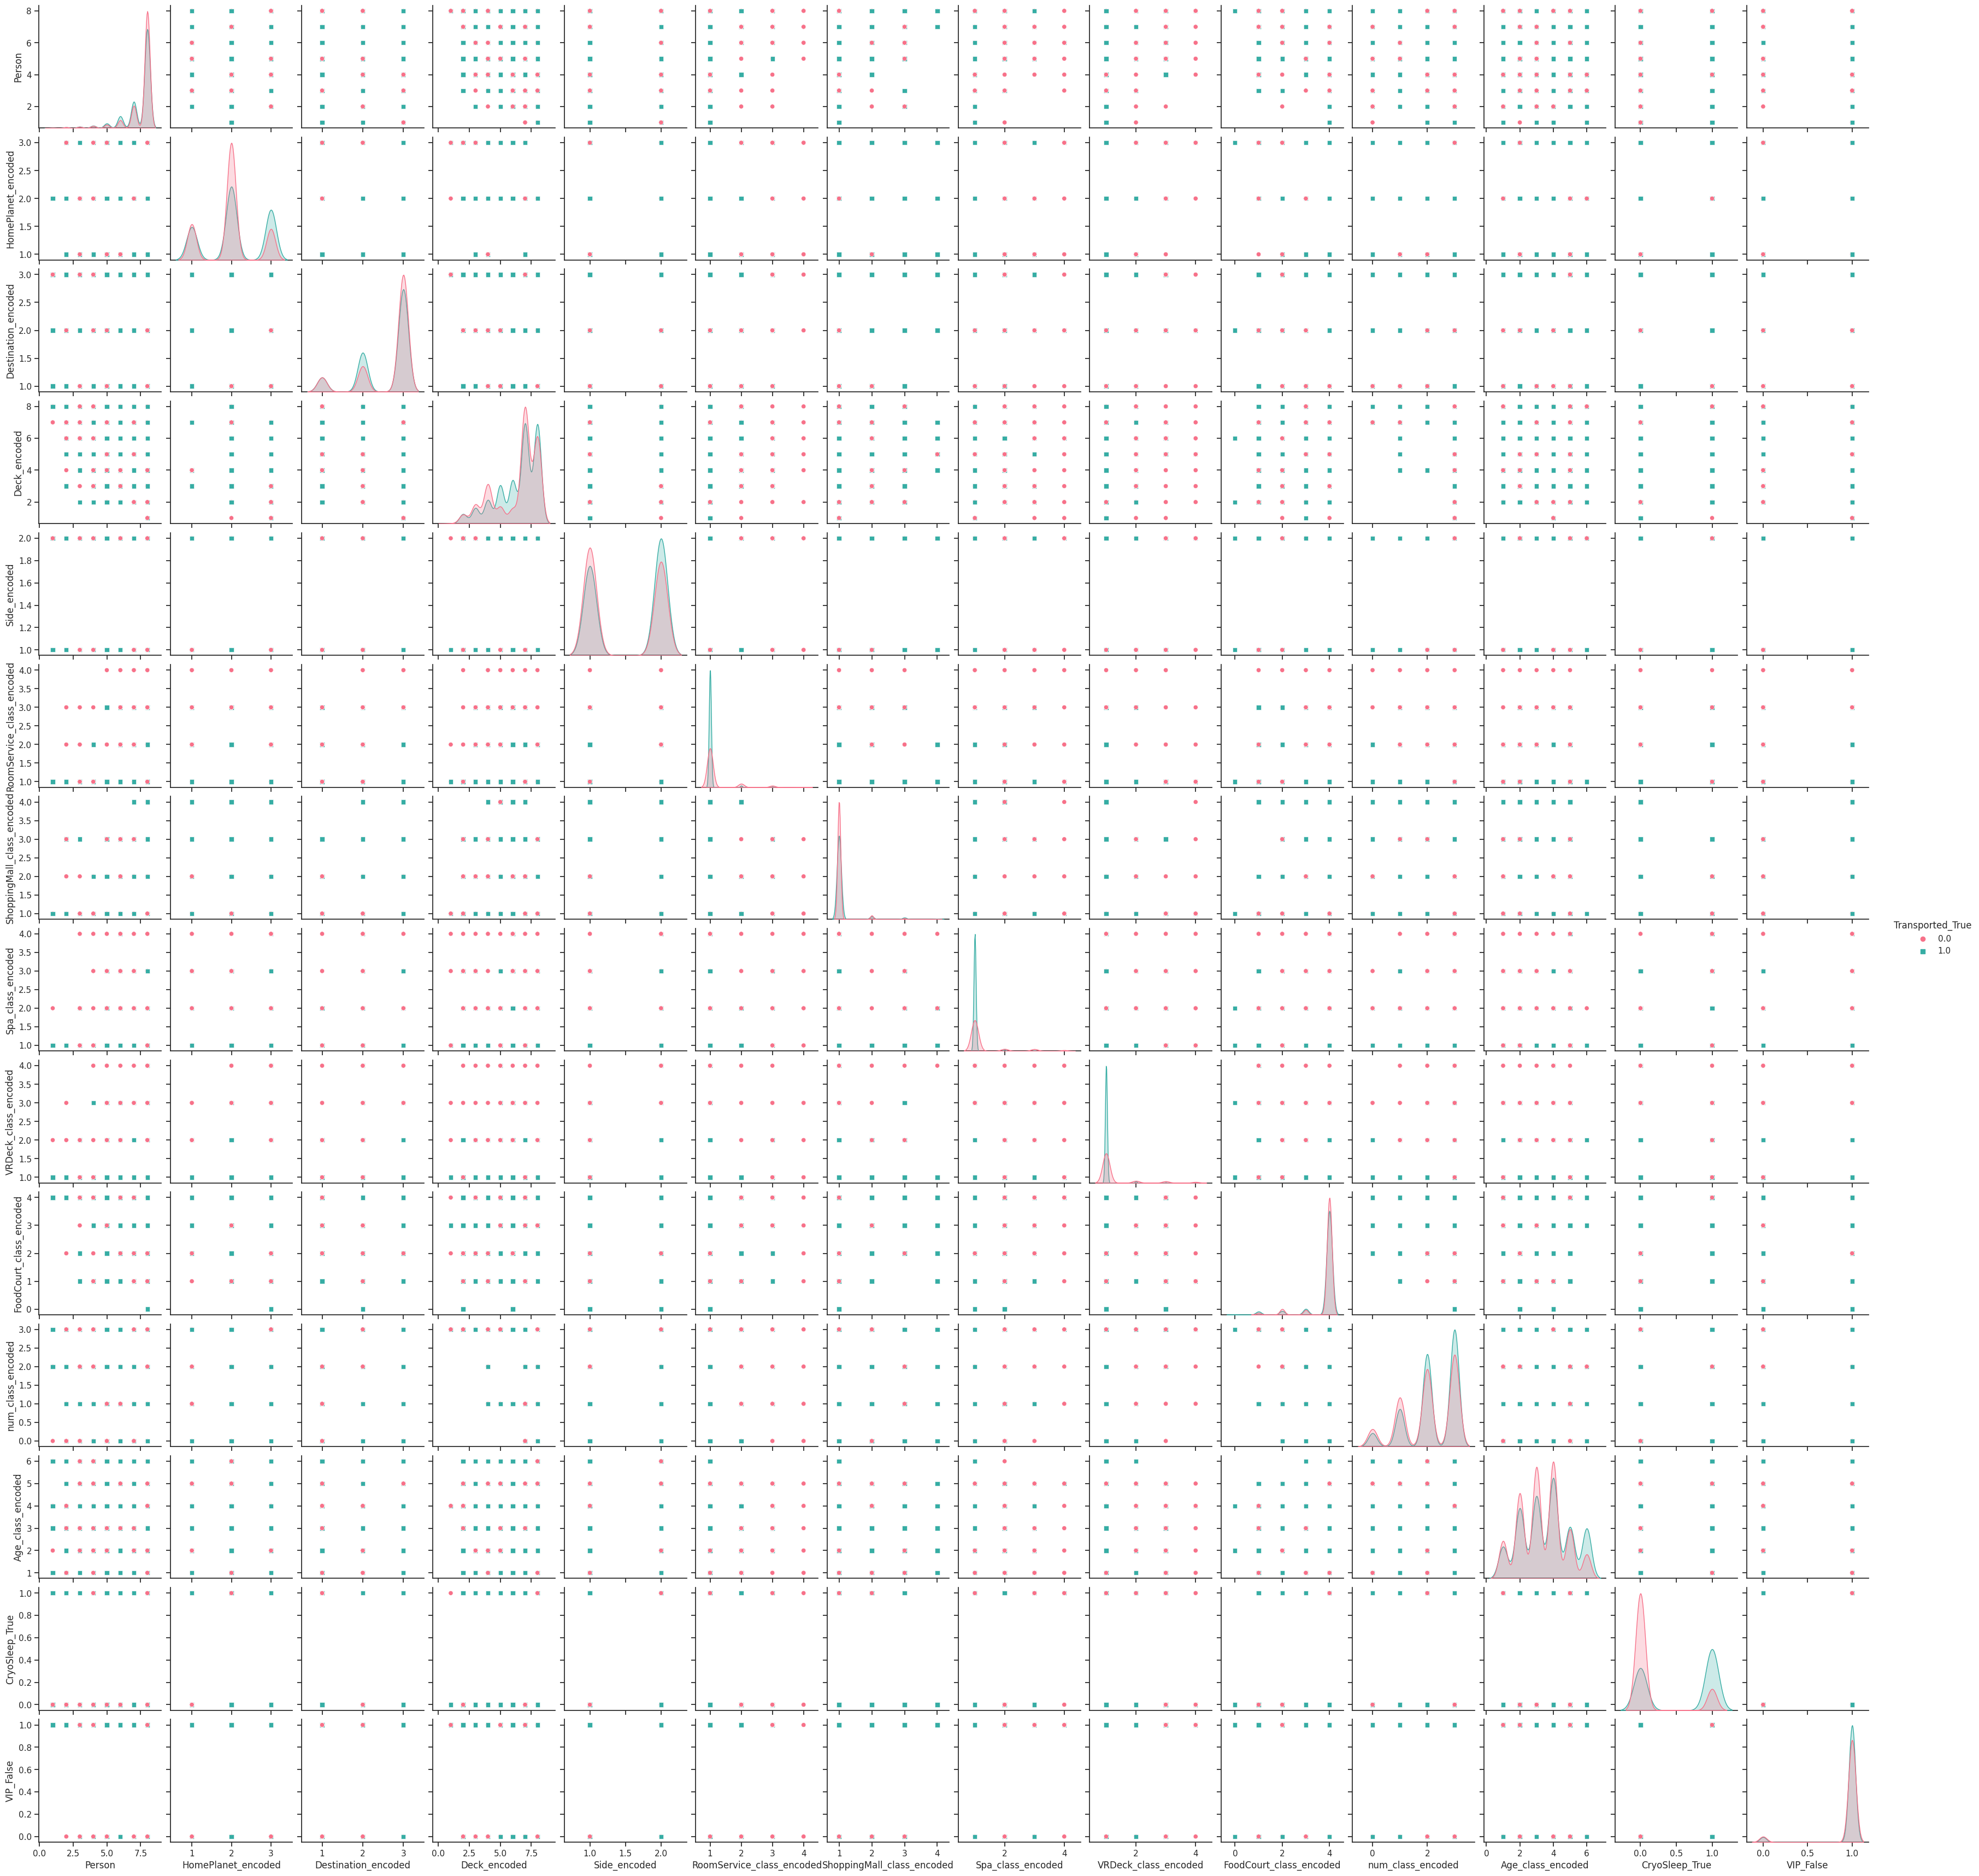

In [24]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(train,hue='Transported_True', palette="husl", markers=["o", "s"], diag_kind="kde", height=2.5)

In [25]:
Xx = train.drop(columns=["Transported_True"])
yy = train[["Transported_True"]]

In [26]:
def scale_dataframe(df):
    # Store the original column names
    original_column_names = df.columns.tolist()

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit and transform the data
    scaled_data = scaler.fit_transform(df)

    # Create a new DataFrame with scaled data and original column names
    scaled_df = pd.DataFrame(scaled_data, columns=original_column_names)

    return scaled_df

In [27]:
test = scale_dataframe(test)

In [28]:
scaled_train = scale_dataframe(Xx)

In [29]:
train = pd.concat([scaled_train, yy], axis =1)

In [30]:
def mahalanobis_with_probability(df):
    # Calculate the mean and covariance matrix of the input DataFrame
    mean = df.mean()
    covariance_matrix = df.cov()

    # Calculate the inverse of the covariance matrix
    inv_covariance_matrix = np.linalg.inv(covariance_matrix)

    # Calculate Mahalanobis distance for each row in the DataFrame
    mahalanobis_distances = []
    for index, row in df.iterrows():
        diff = row - mean
        mahalanobis_distance = np.sqrt(np.dot(np.dot(diff, inv_covariance_matrix), diff))
        mahalanobis_distances.append(mahalanobis_distance)

    # Calculate degrees of freedom based on the number of features
    degrees_of_freedom = len(df.columns)

    # Calculate the chi-square threshold based on the desired probability (e.g., 0.95)
    chi2_threshold = chi2.ppf(0.95, df=degrees_of_freedom)

    # Calculate the probability for each Mahalanobis distance
    probabilities = 1 - chi2.cdf(mahalanobis_distances, df=degrees_of_freedom)

    # Add Mahalanobis distances and corresponding probabilities to the DataFrame
    df['MahalanobisDistance'] = mahalanobis_distances
    df['Probability'] = probabilities

    return df

In [31]:
train = mahalanobis_with_probability(train)

In [32]:
outlierIndexes = np.where(train['Probability'] < 0.01 )

print('--- Index of Outliers ----')
print(outlierIndexes)

--- Index of Outliers ----
(array([], dtype=int64),)


In [33]:
drop_list = ['MahalanobisDistance','Probability']
train = train.drop(columns = drop_list)

In [34]:
manova_train= train.copy()

# Null hypothesis : No significant difference between group mean vectors
# add the intercept
manova_train['Transported_True'] = ['trt ' + str(x) for x in manova_train['Transported_True']]

# fit manova
manova_result = MANOVA.from_formula('Person + HomePlanet_encoded + Destination_encoded + Deck_encoded + Side_encoded + RoomService_class_encoded + ShoppingMall_class_encoded + Spa_class_encoded + VRDeck_class_encoded + FoodCourt_class_encoded + num_class_encoded + Age_class_encoded + CryoSleep_True + VIP_False ~ Transported_True', manova_train)
print(manova_result.mv_test())

# Lambda closer to one, Fvalue greater than F tabular --> reject null hypothesis, meaning that all the independent variables have different contribution in predicting outcome
# Hence, it is meaningful to consider all the fields to predict the outcome.

                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept        Value   Num DF   Den DF  F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.8110 14.0000 8678.0000 144.4530 0.0000
         Pillai's trace 0.1890 14.0000 8678.0000 144.4530 0.0000
 Hotelling-Lawley trace 0.2330 14.0000 8678.0000 144.4530 0.0000
    Roy's greatest root 0.2330 14.0000 8678.0000 144.4530 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
    Transported_True    Value   Num DF   Den DF  F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.6837 14.0000 8678.0000 286.8274 0.0000
         Pillai's trace 0.3163 14.0000 8678.0

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


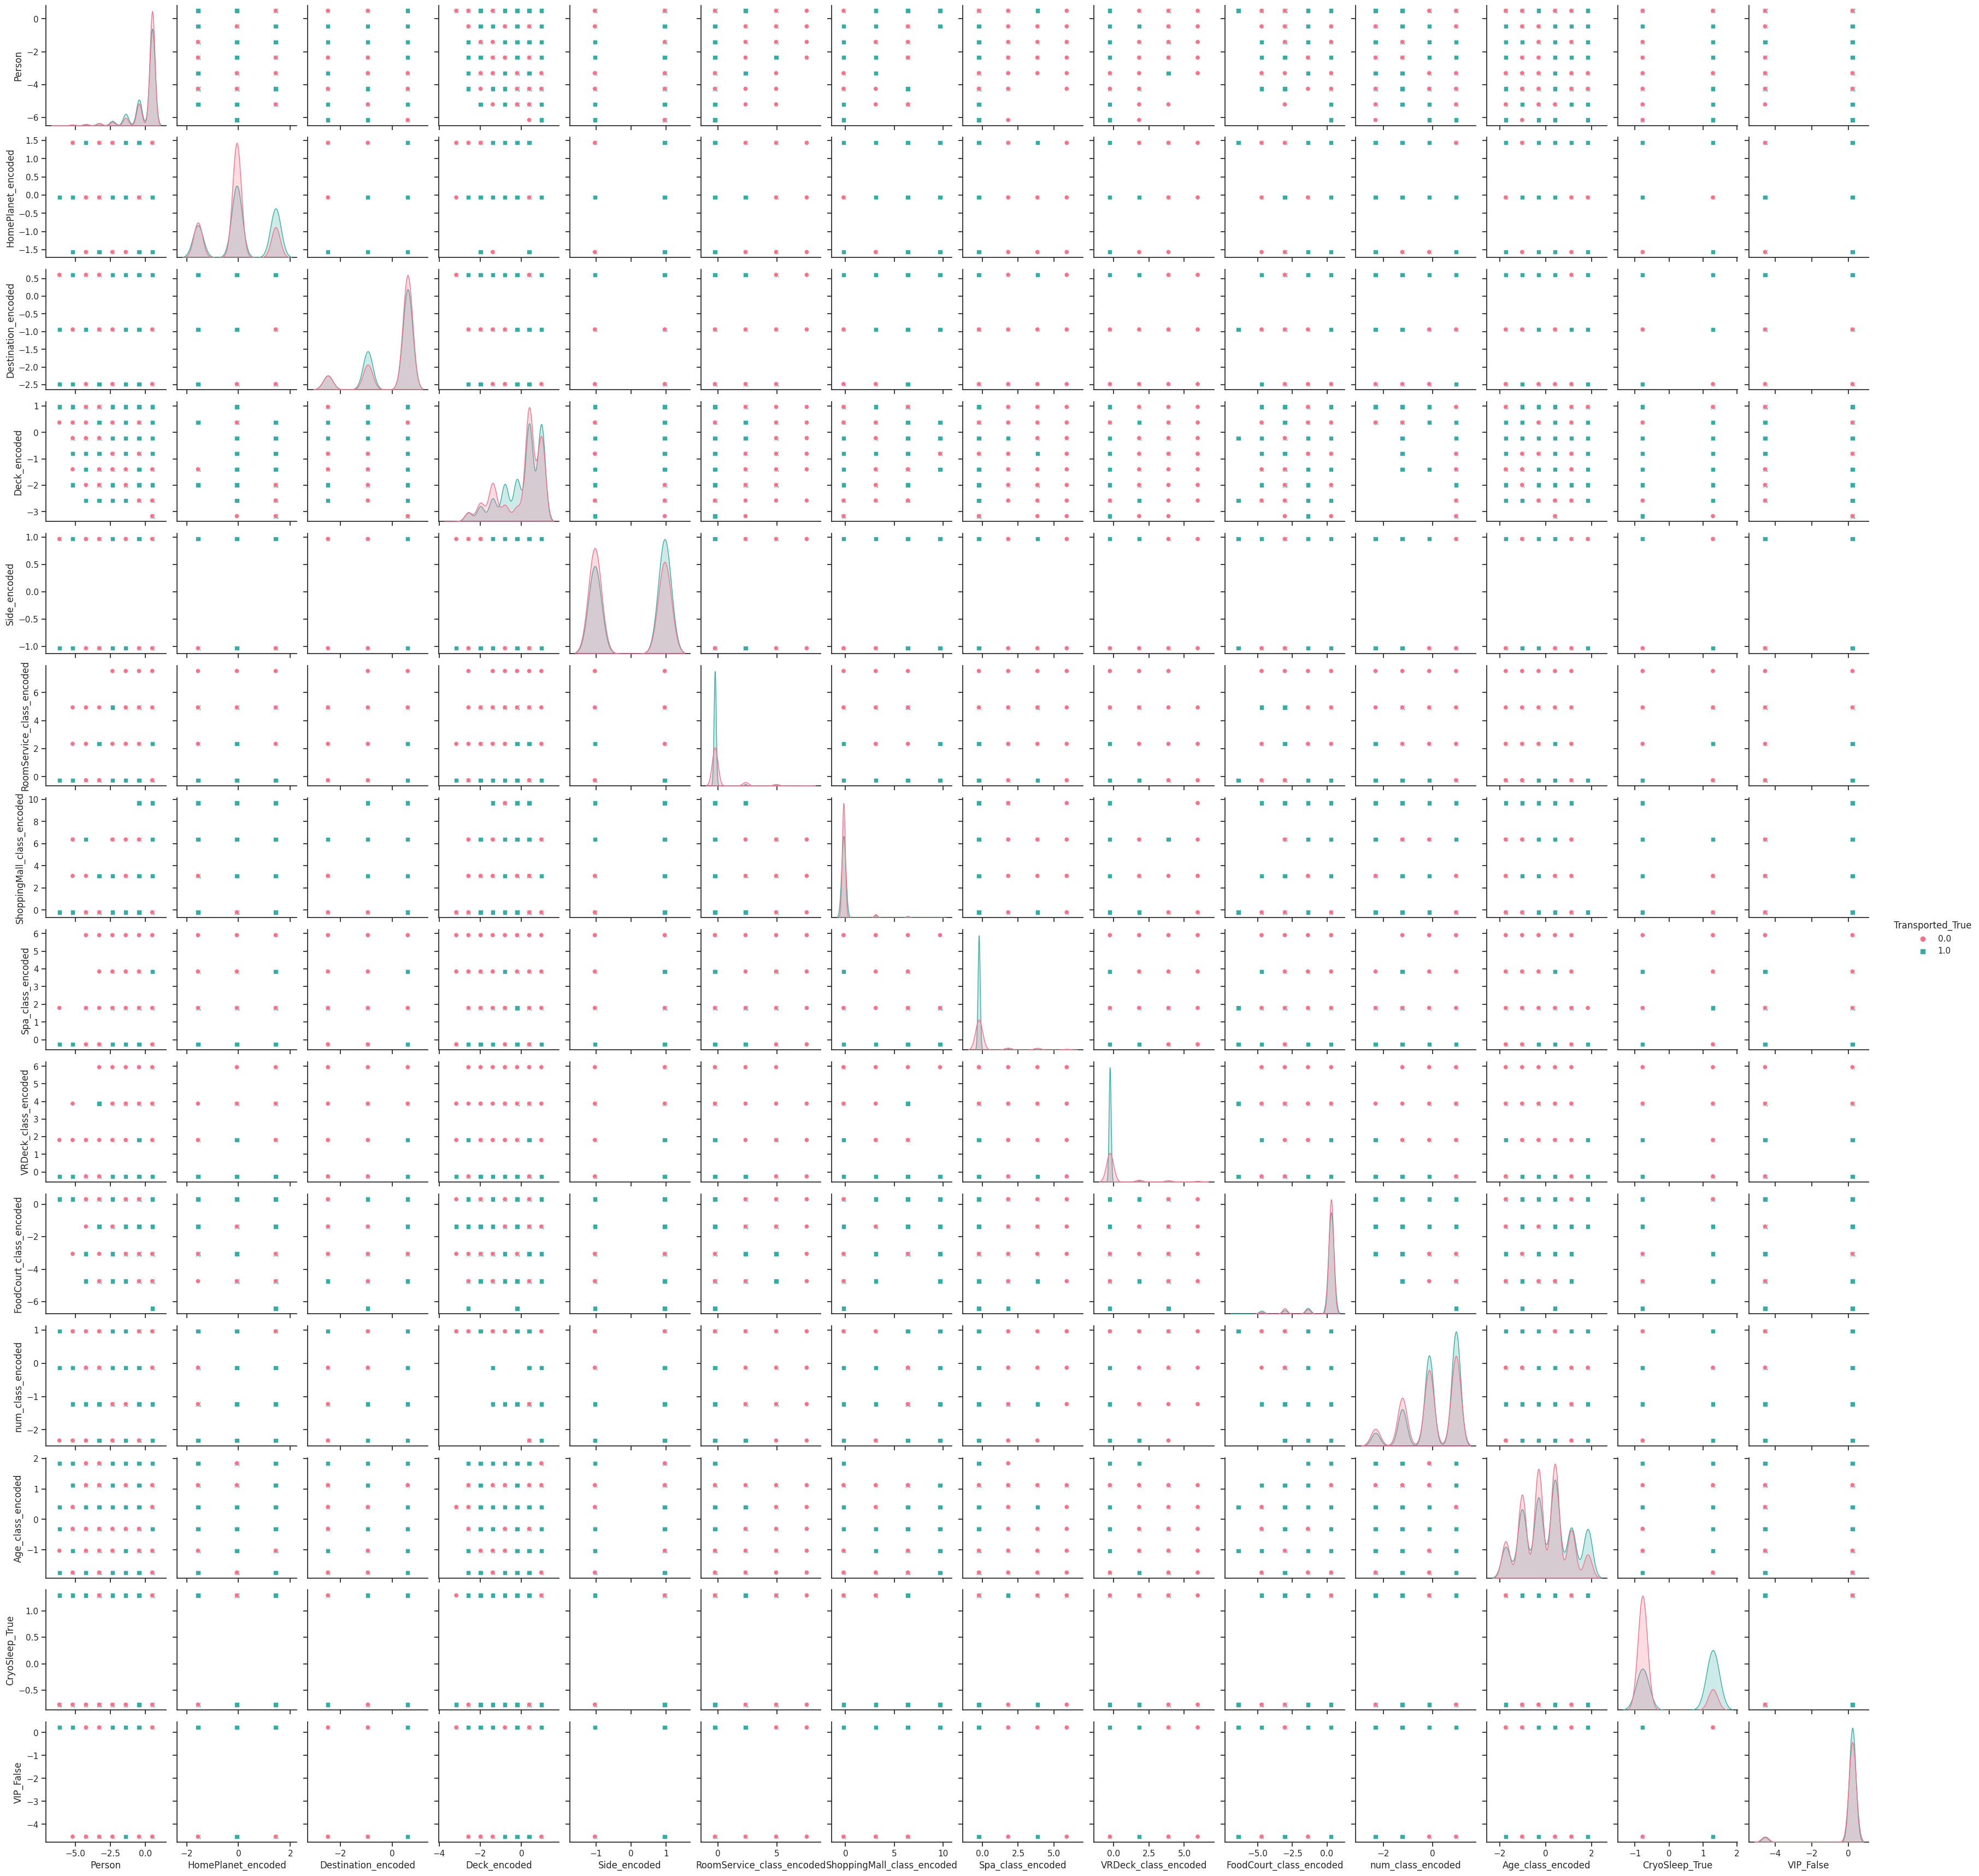

In [35]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(train,hue='Transported_True', palette="husl", markers=["o", "s"], diag_kind="kde", height=2.5)


### Model 1 - Binary classifier model - pytorch

In [36]:
# Define dataset class
class SpaceTitanic(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Add an extra dimension for BCEWithLogitsLoss
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.len

In [37]:
# Load and preprocess data
X = train.drop(columns=["Transported_True"]).values
y = train[["Transported_True"]].values

In [38]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Create datasets and dataloaders
train_dataset = SpaceTitanic(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

In [40]:
# Define the neural network model
class BinaryClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BinaryClassificationModel, self).__init__()
        self.fc = nn.Linear(input_size, hidden_size)  
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc(x))
        x = self.out(x)
        return x

In [41]:
# Initialize model, loss function, and optimizer
NUM_FEATURES = X_train.shape[1]
HIDDEN = 2
model = BinaryClassificationModel(input_size=NUM_FEATURES, hidden_size=HIDDEN)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

In [42]:
# Training loop
NUM_EPOCHS = 2000
losses = []

for epoch in range(NUM_EPOCHS):
    for x, y in train_loader:
        optimizer.zero_grad()
        y_hat_logits = model(x)
        loss = criterion(y_hat_logits, y.squeeze(1))
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    # print loss
    if (epoch % 100 == 0):
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.677911639213562
Epoch 100, Loss: 0.5034102201461792
Epoch 200, Loss: 0.4865179657936096
Epoch 300, Loss: 0.6109471917152405
Epoch 400, Loss: 0.508285641670227
Epoch 500, Loss: 0.6138952970504761
Epoch 600, Loss: 0.3334018886089325
Epoch 700, Loss: 0.36637917160987854
Epoch 800, Loss: 0.32358279824256897
Epoch 900, Loss: 0.43267327547073364
Epoch 1000, Loss: 0.48473677039146423
Epoch 1100, Loss: 0.4399246275424957
Epoch 1200, Loss: 0.38199424743652344
Epoch 1300, Loss: 0.3133079409599304
Epoch 1400, Loss: 0.47177639603614807
Epoch 1500, Loss: 0.41778531670570374
Epoch 1600, Loss: 0.46184468269348145
Epoch 1700, Loss: 0.3712989389896393
Epoch 1800, Loss: 0.6534448862075806
Epoch 1900, Loss: 0.6208056211471558


<Axes: >

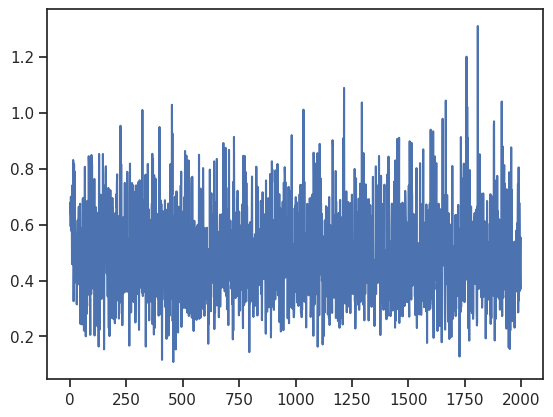

In [43]:
# Show losses over epochs
sns.lineplot(x=range(len(losses)), y=losses)

In [44]:
# Test the model
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    y_test_hat_logits = model(X_test_torch)
    y_test_hat = torch.round(torch.sigmoid(y_test_hat_logits)).squeeze().cpu().numpy()

In [45]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_hat)

# Naive Classifier accuracy
most_common_cnt = Counter(y_test.flatten()).most_common()[0][1]
naive_accuracy = most_common_cnt / len(y_test) * 100

print(f"Model Accuracy: {accuracy * 100:.2f}%")
print(f"Naive Classifier Accuracy: {naive_accuracy:.2f}%")

Model Accuracy: 75.68%
Naive Classifier Accuracy: 50.49%


In [46]:
# model state dict
model.state_dict()
# save model state dict
torch.save(model.state_dict(), 'model_state_dict01.pth')

### Model 2 - LGBM model

In [47]:
print(X_train.shape, y_train.shape)
print(X_test.shape,y_test.shape)

(6954, 14) (6954, 1)
(1739, 14) (1739, 1)


In [48]:
training_score = []
testing_score = []

In [49]:
def model_prediction(model):
    model.fit(X_train,y_train)
    x_train_pred = model.predict(X_train)
    x_test_pred = model.predict(X_test)
    a = accuracy_score(y_train,x_train_pred)*100
    b = accuracy_score(y_test,x_test_pred)*100
    training_score.append(a)
    testing_score.append(b)
    
    print(f"Accuracy_Score of {model} model on Training Data is:",a)
    print(f"Accuracy_Score of {model} model on Testing Data is:",b)
    print("\n------------------------------------------------------------------------")
    print(f"Precision Score of {model} model is:",precision_score(y_test,x_test_pred))
    print(f"Recall Score of {model} model is:",recall_score(y_test,x_test_pred))
    print(f"F1 Score of {model} model is:",f1_score(y_test,x_test_pred))
    print("\n------------------------------------------------------------------------")
    print(f"Confusion Matrix of {model} model is:")
    cm = confusion_matrix(y_test,x_test_pred)
    plt.figure(figsize=(8,4))
    sns.heatmap(cm,annot=True,fmt="g",cmap="summer")
    plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy_Score of LogisticRegression() model on Training Data is: 76.22950819672131
Accuracy_Score of LogisticRegression() model on Testing Data is: 75.15813686026452

------------------------------------------------------------------------
Precision Score of LogisticRegression() model is: 0.764218009478673
Recall Score of LogisticRegression() model is: 0.734624145785877
F1 Score of LogisticRegression() model is: 0.7491289198606272

------------------------------------------------------------------------
Confusion Matrix of LogisticRegression() model is:


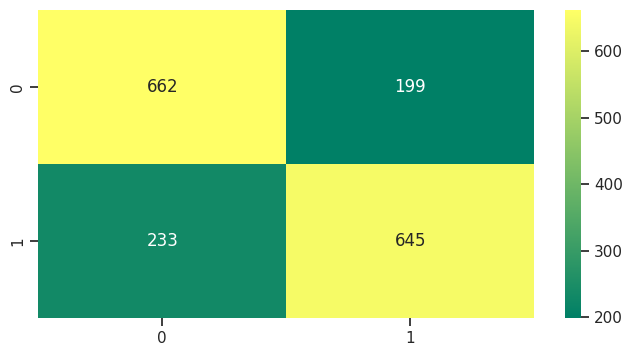

Accuracy_Score of DecisionTreeClassifier() model on Training Data is: 87.94938165084844
Accuracy_Score of DecisionTreeClassifier() model on Testing Data is: 74.00805060379528

------------------------------------------------------------------------
Precision Score of DecisionTreeClassifier() model is: 0.7675879396984925
Recall Score of DecisionTreeClassifier() model is: 0.6958997722095672
F1 Score of DecisionTreeClassifier() model is: 0.7299880525686977

------------------------------------------------------------------------
Confusion Matrix of DecisionTreeClassifier() model is:


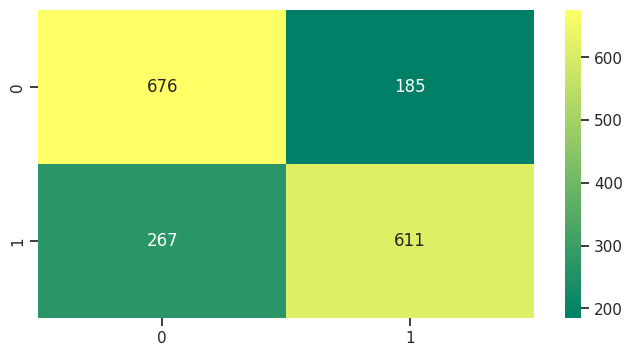

/tmp/ipykernel_20/1891028679.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,y_train)


Accuracy_Score of RandomForestClassifier() model on Training Data is: 87.94938165084844
Accuracy_Score of RandomForestClassifier() model on Testing Data is: 74.81311098332375

------------------------------------------------------------------------
Precision Score of RandomForestClassifier() model is: 0.7619047619047619
Recall Score of RandomForestClassifier() model is: 0.7289293849658315
F1 Score of RandomForestClassifier() model is: 0.7450523864959254

------------------------------------------------------------------------
Confusion Matrix of RandomForestClassifier() model is:


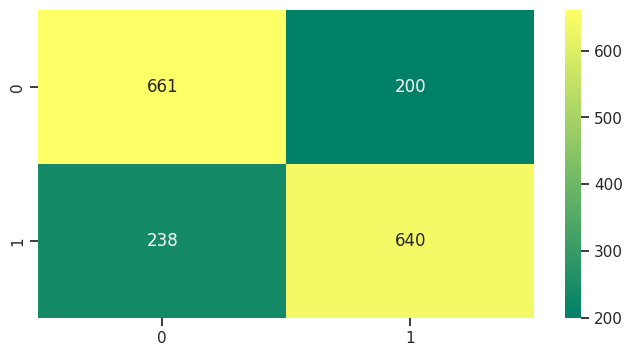

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Accuracy_Score of LGBMClassifier() model on Training Data is: 82.2548173712971
Accuracy_Score of LGBMClassifier() model on Testing Data is: 77.2857964347326

------------------------------------------------------------------------
Precision Score of LGBMClassifier() model is: 0.7941534713763703
Recall Score of LGBMClassifier() model is: 0.7425968109339408
F1 Score of LGBMClassifier() model is: 0.7675103001765744

------------------------------------------------------------------------
Confusion Matrix of LGBMClassifier() model is:


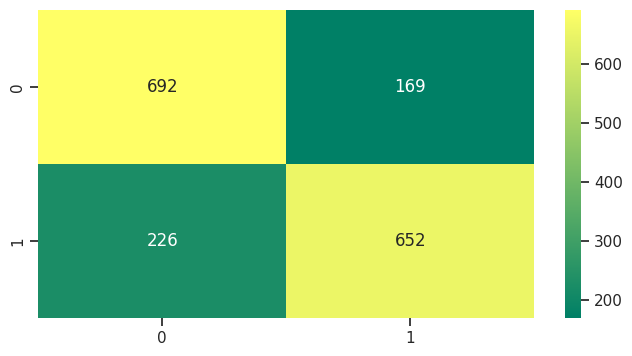

Accuracy_Score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) model on Training Data is: 83.20391141788899
Accuracy_Score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_st

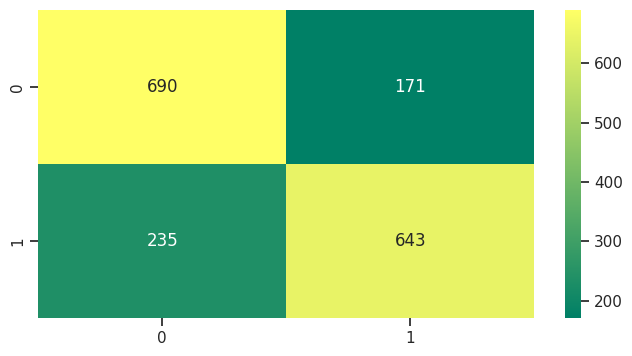

In [50]:
model_prediction(LogisticRegression())
model_prediction(DecisionTreeClassifier())
model_prediction(RandomForestClassifier())
model_prediction(LGBMClassifier())
model_prediction(XGBClassifier())

In [51]:
models = ["Logistic Regression","Decision Tree","Random Forest","LGBM","XGBoost"]

In [52]:
score_results = pd.DataFrame({"Algorithms":models,"Training Score":training_score,"Testing Score":testing_score})

In [53]:
score_results

,Algorithms,Training Score,Testing Score
0,Logistic Regression,76.229508,75.158137
1,Decision Tree,87.949382,74.008051
2,Random Forest,87.949382,74.813111
3,LGBM,82.254817,77.285796
4,XGBoost,83.203911,76.653249


In [54]:
model1 = LGBMClassifier()
parameters1 = {"n_estimators":[100,300,500,600,650],
              "learning_rate":[0.01,0.02,0.03],
              "random_state":[0,42,48,50],
               "num_leaves":[16,17,18]}

In [55]:
grid_search1 = GridSearchCV(model1, parameters1, cv=5, n_jobs=-1)

In [56]:
grid_search1.fit(X_train,y_train.ravel())

GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03],
                         'n_estimators': [100, 300, 500, 600, 650],
                         'num_leaves': [16, 17, 18],
                         'random_state': [0, 42, 48, 50]})

In [57]:
GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03],
                         'n_estimators': [100, 300, 500, 600, 650],
                         'num_leaves': [16, 17, 18],
                         'random_state': [0, 42, 48, 50]})

GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03],
                         'n_estimators': [100, 300, 500, 600, 650],
                         'num_leaves': [16, 17, 18],
                         'random_state': [0, 42, 48, 50]})

In [58]:
grid_search1.best_score_

0.7866006030545801

In [59]:
best_parameters1 = grid_search1.best_params_
best_parameters1

{'learning_rate': 0.01,
 'n_estimators': 500,
 'num_leaves': 18,
 'random_state': 0}

In [60]:
model1 = LGBMClassifier(**best_parameters1)

model1.fit(X_train,y_train)

x_test_pred1 = model1.predict(X_test)

accuracy_score(y_test,x_test_pred1)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


0.7745830937320299

In [61]:
pred = model1.predict(test)

In [62]:
temp = pd.read_csv('/kaggle/input/spacetitanic/test.csv',usecols= ['PassengerId'])

In [63]:
temp["Transported"] = pred
temp["Transported"].replace({1:True,0:False},inplace=True)
temp.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [64]:
temp.shape

(4277, 2)

In [65]:
temp.to_csv("spaceship_prediction_project.csv",index=False)

### NN model output for submission

In [66]:
test_data = test

In [67]:
# Assuming 'test_data' contains the testing features
X_test = test_data.values
# Create a SpaceTitanic object for test data
test_dataset = SpaceTitanic(X_test, np.zeros(X_test.shape[0]))  
# Dummy zeros as labels, not used during prediction
test_loader = DataLoader(dataset=test_dataset, batch_size=32)

In [68]:
predictions = []

with torch.no_grad():
    for x, _ in test_loader:  # We use a dummy label, so the second element in the tuple is not used
        y_test_hat_logits = model(x)
        y_test_hat = torch.round(torch.sigmoid(y_test_hat_logits)).squeeze().cpu().numpy()
        predictions.extend(y_test_hat)

In [69]:
len(predictions)

4277

In [70]:
temp2 = pd.read_csv('/kaggle/input/spacetitanic/test.csv',usecols= ['PassengerId'])

In [71]:
temp2["Transported"] = predictions
temp2["Transported"].replace({1:True,0:False},inplace=True)
temp2.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [72]:
temp2.shape

(4277, 2)

In [73]:
temp2.to_csv("spaceship_prediction_project01.csv",index=False)